<a href="https://colab.research.google.com/github/aakhterov/papers/blob/master/A%20Neural%20Probabilistic%20Language%20Model/A_Neural_Probabilistic_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A NEURAL PROBABILISTIC LANGUAGE MODEL (2003)**

Implementation a language model from this paper using Tensorflow.

Paper:  [A NEURAL PROBABILISTIC LANGUAGE MODEL](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

Similar implementation using PyTorch: https://github.com/graykode/nlp-tutorial

In [ ]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk import FreqDist
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Dense, TextVectorization, Input, Flatten
from tensorflow.keras.activations import softmax
from sklearn.model_selection import train_test_split

In [ ]:
# Mount a Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# parameters
n_before = 2 # n-1 in paper
m = 20 # m in paper
h = 30 # h in paper
words_freq_thr = 2 # rare words with frequency <= this threshold are replacing by the token filler_for_rare_words
filler_for_rare_words = 'rareword' # filler for rare words

In [ ]:
# read book from Google Disk
paragraphs = []
path_to_file = "/content/drive/MyDrive/Colab Notebooks/Data/Asimov_Isaac_I_Robot.txt"
with open(path_to_file, mode='r') as file:
  for line in file:
    if line[:-1].strip() != '': # line[:-1] because the last symbol is '\n'
      paragraphs.append(line[:-1])

In [ ]:
# take a look at the first 5 paragraphs
paragraphs[:5]

['Isaac Asimov',
 'I, Robot',
 'Introduction',
 "I LOOKED AT MY NOTES AND I DIDN'T LIKE THEM. I'd spent three days at U. S. Robots and might as well have spent them at home with the Encyclopedia Tellurica.",
 "Susan Calvin had been born in the year 1982, they said, which made her seventy-five now. Everyone knew that. Appropriately enough, U. S. Robot and Mechanical Men, Inc. was seventy-five also, since it had been in the year of Dr. Calvin's birth that Lawrence Robertson had first taken out incorporation papers for what eventually became the strangest industrial giant in man's history. Well, everyone knew that, too."]

In [ ]:
# split paragraphs on sentences using regular expressions.
# We consider that at the end of the sentence can be one of the following symbols - '.', '?' or '!'.
sentences = []
for par in paragraphs:
  sentences += [s.strip() for s in re.split(r'\.|!|\?', par) if s.strip()]

In [ ]:
# take a look at the sentences
sentences[:10]

['Isaac Asimov',
 'I, Robot',
 'Introduction',
 "I LOOKED AT MY NOTES AND I DIDN'T LIKE THEM",
 "I'd spent three days at U",
 'S',
 'Robots and might as well have spent them at home with the Encyclopedia Tellurica',
 'Susan Calvin had been born in the year 1982, they said, which made her seventy-five now',
 'Everyone knew that',
 'Appropriately enough, U']

In [ ]:
# preprocessing and making dataset:
# 1) remove all except letters and numbers
# 2) split the sentences on n-gramms: n_before + 1 words
data = []
all_words = [] # list of all words. It needs for counting word frequencies
for sent in sentences:
  words = re.sub(r'[^a-z0-9\s]', ' ', sent.lower()).split()
  all_words += words
  for i in range(0, len(words)-n_before):
    data.append(' '.join(words[i:i+n_before+1]))

In [ ]:
data[:5]

['i looked at', 'looked at my', 'at my notes', 'my notes and', 'notes and i']

In [ ]:
print(f"Total number of n-gramms: {len(data)}")

Total number of n-gramms: 58981


Next, we want to replace the words with frequency <= words_freq_thr by the appropriate filler - filler_for_rare_words

In [ ]:
# use class FreqDist from nltk library for counting word frequencies
freq = FreqDist(all_words)

In [ ]:
vocabulary = [pair[0] for pair in freq.most_common() if pair[1] > words_freq_thr] # leave word with frequency > words_freq_thr

In [ ]:
len(vocabulary), len(freq) # compare the new vocabulary's length with the old one's length.

(2542, 7363)

In [ ]:
# replace rare words (words that aren't in the new vocabulary)by filler - filler_for_rare_words
for idx, collacation in enumerate(data):
  new = []
  for word in collacation.split():
    if word in vocabulary:
      new.append(word)
    else:
      new.append(filler_for_rare_words)
  data[idx] = ' '.join(new)

In [ ]:
# use class TextVectorization to transform n-gramms to the sets of integer numbers (integer numbers ara indices of the words in the vocabulary)
text_vectorization = TextVectorization()
text_vectorization.adapt(data, batch_size=64)
sentences_indices = text_vectorization(data)
sentences_indices.shape

TensorShape([58981, 3])

In [ ]:
vocabulary = text_vectorization.get_vocabulary()

In [ ]:
vocabulary[:10]

['', '[UNK]', 'rareword', 'the', 'and', 'of', 'a', 'to', 'you', 'in']

In [ ]:
X, y = sentences_indices[:, :n_before].numpy(), sentences_indices[:, n_before].numpy() # The first n_before columns is X and the last column is target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # split on train and test datasets

In [ ]:
# make a NN according to the paper
def NPLM(input_shape, vocabulary, embedding_dim, h):
  inputs = Input(input_shape)
  x = Embedding(input_dim=len(vocabulary), output_dim=embedding_dim)(inputs)
  x = Flatten()(x)
  out1 = Dense(units=h, use_bias=True)(x)
  out1 = tf.math.tanh(out1)
  out1 = Dense(units=len(vocabulary), use_bias=False)(out1)
  out2 = Dense(units=len(vocabulary), use_bias=True)(x)
  y = out1 + out2
  prob = softmax(y)
  model = Model(inputs=inputs, outputs=prob)
  return model

In [ ]:
model = NPLM(input_shape=((n_before)), vocabulary=vocabulary, embedding_dim=m, h=h)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 2, 20)        50860       ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 40)           0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 30)           1230        ['flatten[0][0]']                
                                                                                              

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test)
                    )

Epoch 1/10
1475/1475 [==============================] - 18s 12ms/step - loss: 6.2030 - sparse_categorical_accuracy: 0.0940 - val_loss: 5.7894 - val_sparse_categorical_accuracy: 0.1095
Epoch 2/10
1475/1475 [==============================] - 19s 13ms/step - loss: 5.6440 - sparse_categorical_accuracy: 0.1236 - val_loss: 5.5438 - val_sparse_categorical_accuracy: 0.1354
Epoch 3/10
1475/1475 [==============================] - 18s 12ms/step - loss: 5.4753 - sparse_categorical_accuracy: 0.1393 - val_loss: 5.4747 - val_sparse_categorical_accuracy: 0.1403
Epoch 4/10
1475/1475 [==============================] - 16s 11ms/step - loss: 5.4102 - sparse_categorical_accuracy: 0.1469 - val_loss: 5.4380 - val_sparse_categorical_accuracy: 0.1462
Epoch 5/10
1475/1475 [==============================] - 15s 10ms/step - loss: 5.3583 - sparse_categorical_accuracy: 0.1521 - val_loss: 5.4178 - val_sparse_categorical_accuracy: 0.1473
Epoch 6/10
1475/1475 [==============================] - 18s 12ms/step - loss: 5.

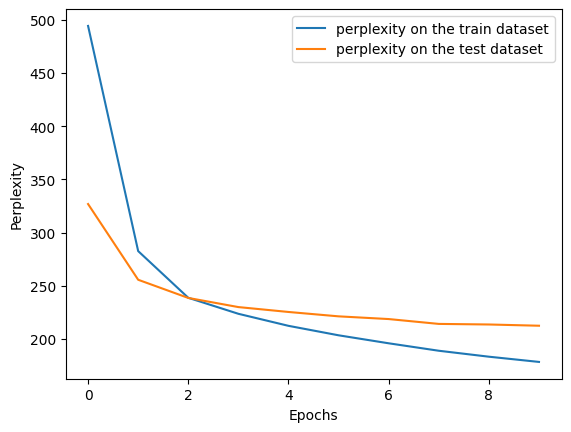

In [61]:
from nltk.downloader import Label
# plot Perplexity metrics on train and test datasets
_, _ = plt.subplots(1, 1)
sns.lineplot(data=np.exp(history.history['loss']), label='perplexity on the train dataset')
sns.lineplot(data=np.exp(history.history['val_loss']), label='perplexity on the test dataset')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()